### Imports and Settings

In [1]:
import mne
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorly as tl
import gc

%matplotlib inline

### Load data

Specify directory for one subject's data

In [2]:
data_path = '/Users/Bella/Desktop/Grosenick_Lab/eeg_patient_data/mdd_dlpfc/subject9_m191_dlpfc_58/m191_dlpfc_day1/m191_dlpfc_day1_treatment_20230424_021417.mff'
raw = mne.io.read_raw_egi(data_path, preload=True)

Reading EGI MFF Header from /Users/Bella/Desktop/Grosenick_Lab/eeg_patient_data/mdd_dlpfc/subject9_m191_dlpfc_58/m191_dlpfc_day1/m191_dlpfc_day1_treatment_20230424_021417.mff...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {} ...
Reading 0 ... 720329  =      0.000 ...   720.329 secs...


### Highpass and lowpass filtering

In [3]:
raw.info['bads'] = ['VREF']
raw_filt = raw.filter(l_freq=1, h_freq=None, method='fir', verbose='warning')

### Create epochs

In [4]:
# Read DIN1 events for TMS data create epochs based on stim triggers
events = mne.find_events(raw_filt, stim_channel = 'DIN1')
events = events[:150]
epochs = mne.Epochs(raw_filt, events, tmin=-0.1, tmax=0.1, baseline=(0, 0), preload=True)

600 events found on stim channel DIN1
Event IDs: [1]
Not setting metadata
150 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 150 events and 201 original time points ...
0 bad epochs dropped


In [5]:
timepoints = raw_filt.times
print(timepoints)

[0.00000e+00 1.00000e-03 2.00000e-03 ... 7.20327e+02 7.20328e+02
 7.20329e+02]


Do not resample before the Tucker decomposition!! Causes kernel to die

In [6]:
# Resample to 200 Hz
# Resample after epoching to avoid jittering trigger timings
#epochs.resample(200)

In [7]:
epochs._data.shape

(150, 259, 201)

### Tucker decomposition

In [8]:
import tensorly as tl
from tensorly.decomposition import tucker

epoch_data = epochs.get_data(copy=True)[:,0:257,:]
epoch_stim = epochs.get_data(copy=True)[:,257:,:]

In [12]:
import time
tic = time.time()
tucker_decomp = tucker(epoch_data, 150)  # Tried changing rank value to 250. Kernel dies at 250, 200, 150, 120, 115, 110, 105
                                         # With 300 events, decomposition runs with 200
                                         # With 200 events, kernel dies at 250
                                         # With 150 events and 250 components, it took 53507 seconds to fit on my Mac
                                         # With 150 event and 150 components it takes 9.7 sec
print(time.time()-tic)

# try fitting the decomposition 50-100 times
# then aggregate the values of the diagnoal of the core tensor and plot in hist

8.956209897994995


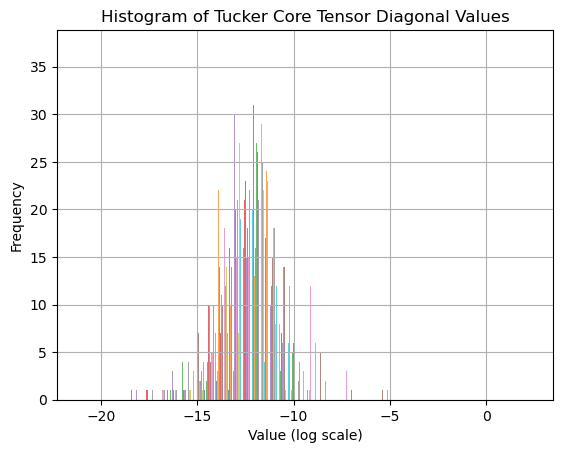

1274.939481973648


In [22]:
import time
tic = time.time()

# Fit tucker decomposition to data 100 times

# Define the number of iterations
n_iterations = 100

# Initialize an empty list to store the diagonal values of the core tensor
core_diagonal_values = []

# Perform Tucker decomposition for each iteration
for i in range(n_iterations):
    # Fit Tucker decomposition
    tucker_decomp = tucker(epoch_data, 150)
    
    # Get the core tensor diagonal values
    # And convert to log scale for visualization
    core_tensor = tucker_decomp[0]
    core_diagonal = np.diagonal(core_tensor)
    log_core_diagonal = np.log(np.abs(core_diagonal))
    
    # Append diagonal values to core_diagonal_values
    core_diagonal_values.extend(log_core_diagonal)

# Plot histogram of diagonal values
plt.hist(core_diagonal_values, bins=50, alpha=0.7)
plt.title('Histogram of Tucker Core Tensor Diagonal Values')
plt.xlabel('Value (log scale)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(time.time()-tic)
# 1274 s

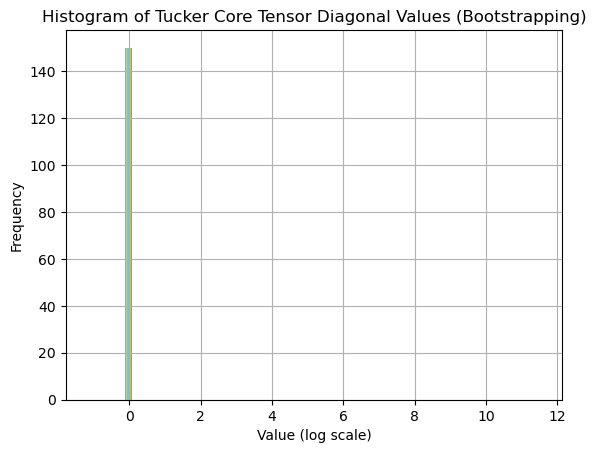

1374.005187034607


In [24]:
# try with actual boostrapping
n_iterations = 100
core_diagonal_values = []
tic = time.time()

# Perform Tucker decomposition for each iteration
for i in range(n_iterations):
    # Sample with replacement to create a bootstrapped dataset
    bootstrap_indices = np.random.choice(len(epoch_data), len(epoch_data), replace=True)
    bootstrap_sample = epoch_data[bootstrap_indices]
    
    # Fit Tucker decomposition on the bootstrapped sample
    tucker_decomp = tucker(bootstrap_sample, 150)
    
    # Get the core tensor, extract diagonal values, log values for visualization
    core_tensor = tucker_decomp[0]
    core_diagonal = np.diagonal(core_tensor)
    log_core_diagonal = np.log(np.abs(core_diagonal))
    core_diagonal_values.extend(log_core_diagonal)

# Plot histogram of diagonal values (log scale)
plt.hist(core_diagonal_values, bins=50, alpha=0.7)
plt.title('Histogram of Tucker Core Tensor Diagonal Values (Bootstrapping)')
plt.xlabel('Value (log scale)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(time.time()-tic)

Text(0, 0.5, 'Log Diagonal of Core Tensor Value')

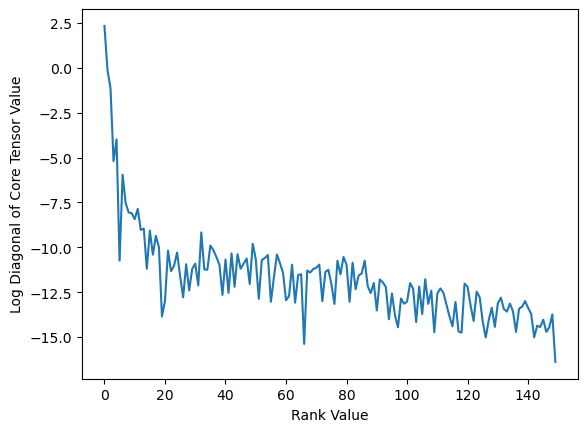

In [14]:
%matplotlib inline
# Plot tensor equivalent of singular values (diagonal of core tensor)
def get_3dtensor_diag(tensor):
    diag = []
    for i in range(tensor.shape[0]):
        diag.append(tensor[i,i,i])
    return np.array(diag)
tucker_diag = get_3dtensor_diag(tucker_decomp.core)
diagonal_core_tensor = np.abs(tucker_diag)
log_diagonal_core_tensor = np.log(np.abs(tucker_diag))


diag_indices = np.arange(len(log_diagonal_core_tensor))
plt.plot(diag_indices, log_diagonal_core_tensor)
plt.xlabel('Rank Value')
plt.ylabel('Log Diagonal of Core Tensor Value')

diagonal core tensor values: [1.03375673e+01 8.90698852e-01 3.23352122e-01 5.50786470e-03
 1.85784089e-02 2.15778526e-05 2.58997358e-03 5.34636740e-04
 3.16147345e-04 3.03926485e-04 2.17859744e-04 3.87941892e-04
 1.19568730e-04 1.28569425e-04 1.36831500e-05 1.15780555e-04
 3.01685221e-05 8.59682846e-05 4.58829655e-05 9.66351189e-07
 2.27520951e-06 3.78040664e-05 1.19803585e-05 1.62900214e-05
 3.39038619e-05 9.17977302e-06 2.80014674e-06 1.76843462e-05
 4.11695126e-06 1.36593840e-05 1.82675920e-05 5.41955705e-06
 1.03888050e-04 1.32866160e-05 1.29377916e-05 5.02041035e-05
 3.86542358e-05 2.63523491e-05 1.71310997e-05 3.20628544e-06
 2.28677565e-05 3.58755654e-06 3.22851869e-05 5.03734512e-06
 3.08073478e-05 1.37867439e-05 1.83958184e-05 2.42620028e-05
 5.88614006e-06 5.51081882e-05 2.35301198e-05 2.57052426e-06
 2.24577433e-05 2.50042761e-05 2.95164236e-05 2.17366010e-06
 8.55430953e-06 3.04925801e-05 1.86807032e-05 1.10348384e-05
 2.37018127e-06 3.01145779e-06 1.72222225e-05 2.06627414

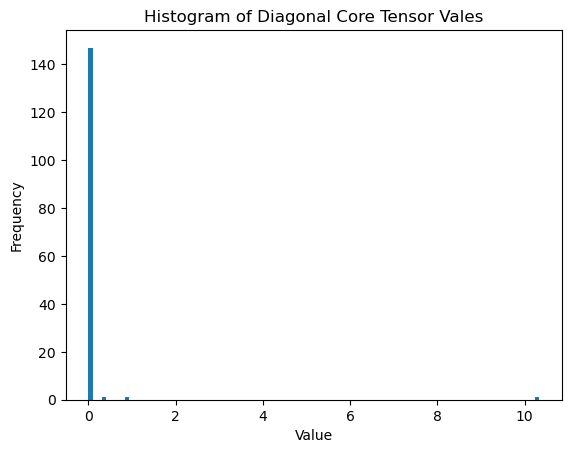

In [15]:
from scipy.stats import mode, kurtosis
%matplotlib inline

plt.hist(diagonal_core_tensor, bins = 100)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Diagonal Core Tensor Vales')

print(f'diagonal core tensor values: {diagonal_core_tensor}')
normal_mode = mode(diagonal_core_tensor)[0]
print(f'Mode of diagonal core tensor values: {normal_mode}')
print(f'Kurtosis of diagonal core tensor values: {kurtosis(diagonal_core_tensor)}')
print(f'Count of values above 0.1: {np.sum(diagonal_core_tensor > 0.1)}')

log values of diagonal core tensor: [  2.33578457  -0.1157489   -1.12901339  -5.20157826  -3.98575518
 -10.74384311  -5.95610761  -7.53392303  -8.05930217  -8.09872471
  -8.43165908  -7.85465499  -9.0316192   -8.95904153 -11.19934541
  -9.06381392 -10.40871149  -9.36153211  -9.98941663 -13.84973852
 -12.99343842 -10.18309388 -11.33224204 -11.02495782 -10.29198163
 -11.59850808 -12.78583874 -10.94283071 -12.40039765 -11.2010838
 -10.910382   -12.12549647  -9.17219668 -11.22875335 -11.25535795
  -9.89941379 -10.1608542  -10.54395314 -10.97461505 -12.65039747
 -10.68578265 -12.53803922 -10.34090204 -12.19863138 -10.38775733
 -11.19180302 -10.90338718 -10.6265991  -12.04291011  -9.80621225
 -10.65722926 -12.87140069 -10.70387509 -10.5964637  -10.43056372
 -13.03909813 -11.66907536 -10.39802718 -10.88801948 -11.41445316
 -12.95254412 -12.71308628 -10.96931    -13.0897635  -11.54289682
 -11.50012493 -15.38409113 -11.29648218 -11.40467948 -11.2056411
 -11.14151598 -10.96467028 -12.9993748  -1

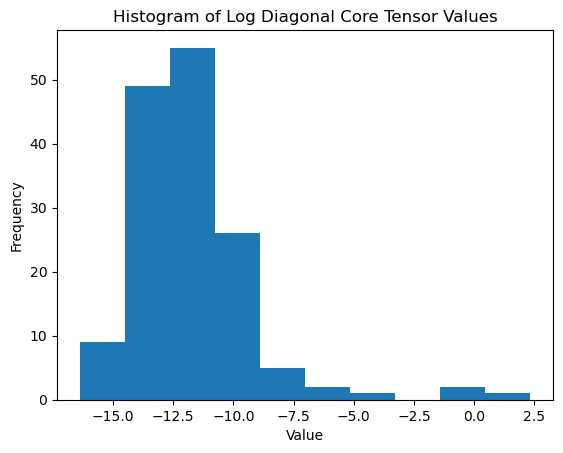

In [16]:
print(f'log values of diagonal core tensor: {log_diagonal_core_tensor}')
log_diagonal_int = []
for value in log_diagonal_core_tensor:
    log_diagonal_int.append(int(value))
print(f'log int values: {log_diagonal_int}')

plt.hist(log_diagonal_core_tensor)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Log Diagonal Core Tensor Values')

#hist, bins = np.histogram(log_diagonal_core_tensor, bins='auto')
# Find bin with highest frequency
#max_freq_bin = bins[np.argmax(hist)]

#print("Mode of the values:", max_freq_bin)


log_mode = mode(log_diagonal_int)[0]
print(f'Mode of log diagonal core tensor values: {log_mode}')  # -13
print(f'Kurtosis of log diagonal core tensor values: {kurtosis(log_diagonal_int)}')  # 7.857279900230186 --> leptokurtic

In [16]:
# Identify fist appearance of mode value, then remove that many components
# Should result in removing the largest values, which most likely are reproduceable values in the MP distribution that roughly correspond to the artifact
log_mode_index = np.where(log_diagonal_int == log_mode)[0]
print(log_mode_index)
components_to_remove = log_mode_index[0]
print(components_to_remove)

[ 14  29  31  34  40  46  51  52  54  55  56  57  58  59  61  62  63  66
  69  73  75  76  77  79  84  85  86  88  90  92  94  96  99 101 102 109
 115 122]
14


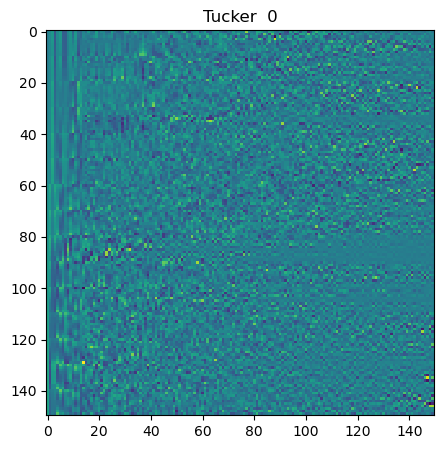

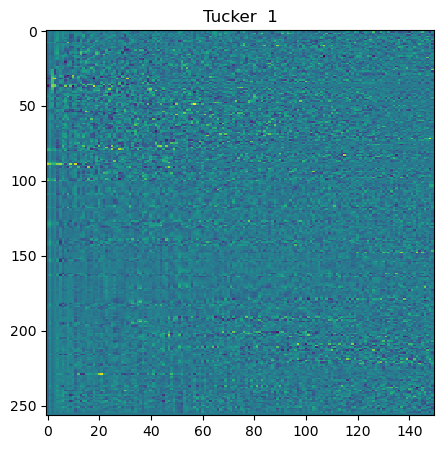

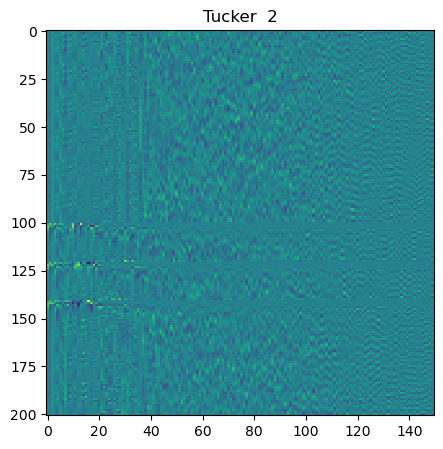

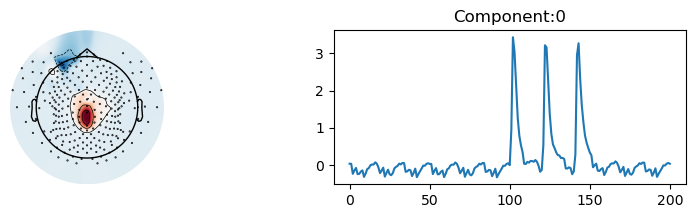

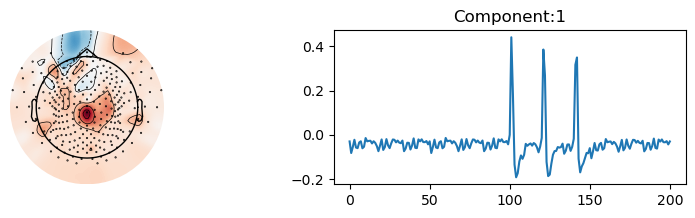

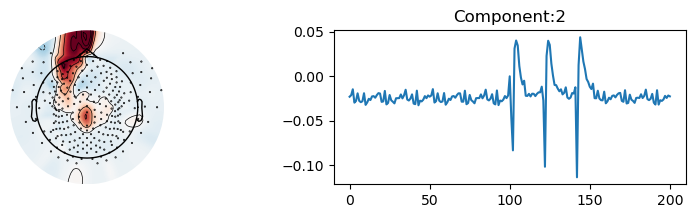

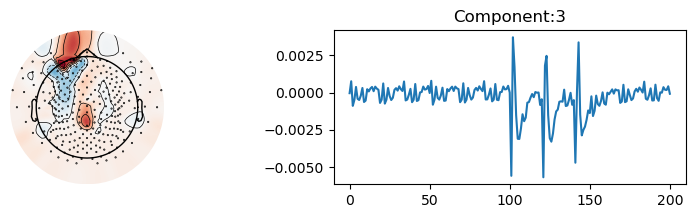

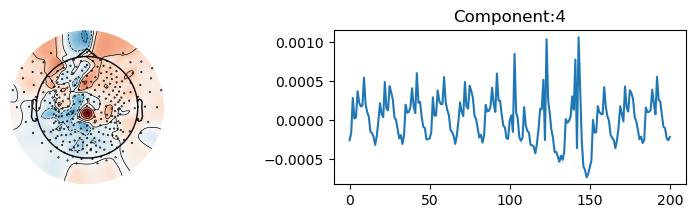

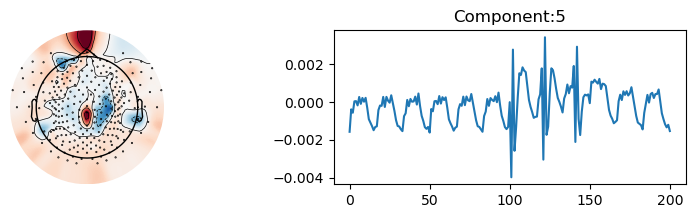

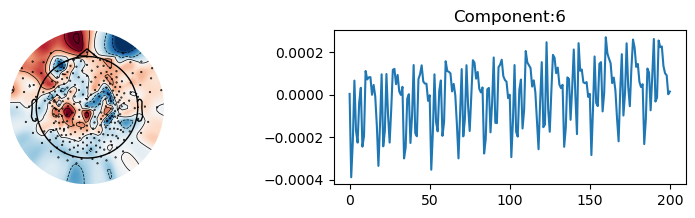

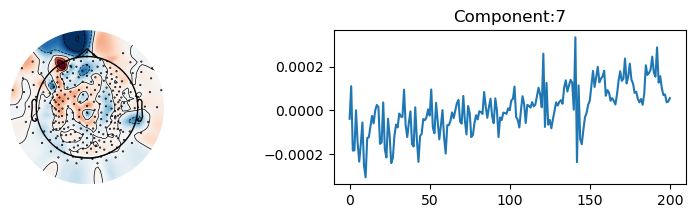

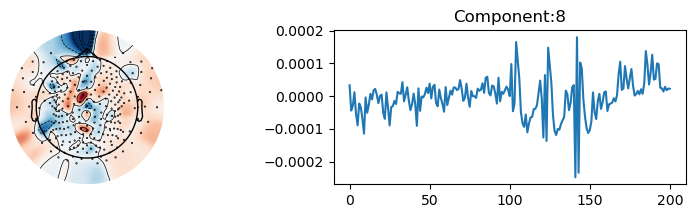

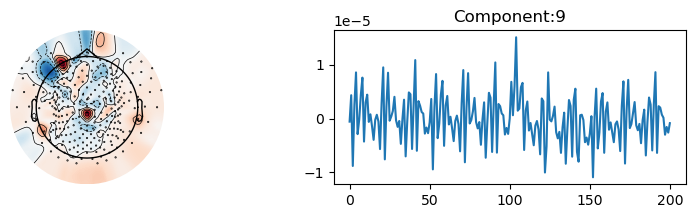

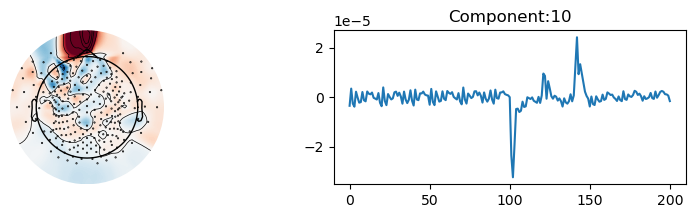

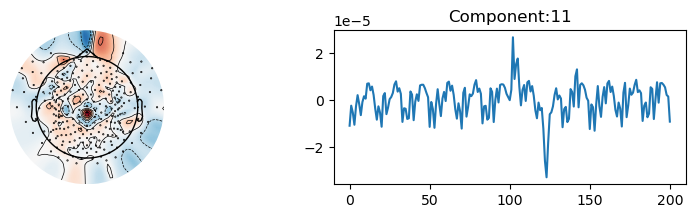

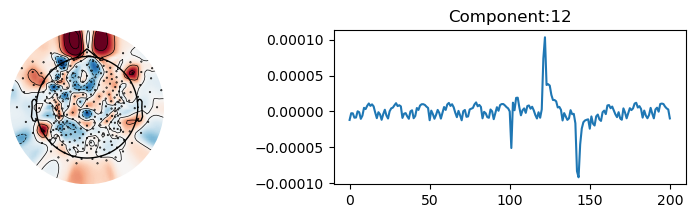

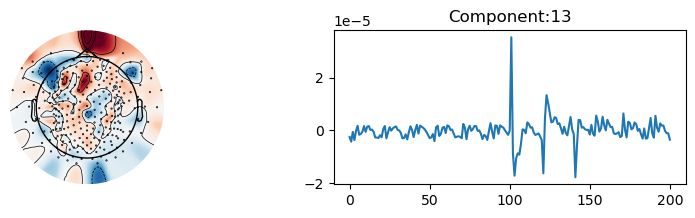

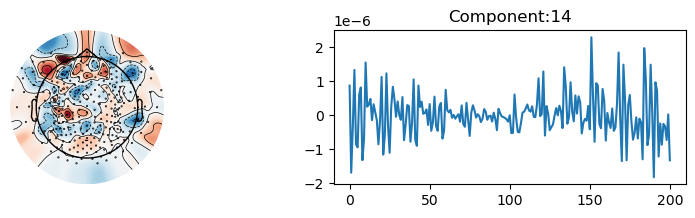

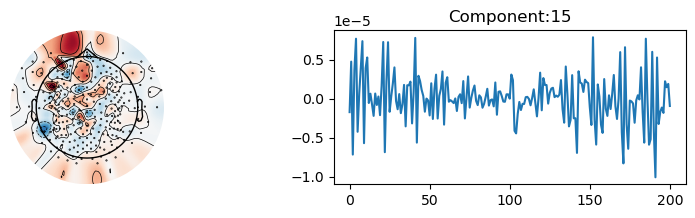

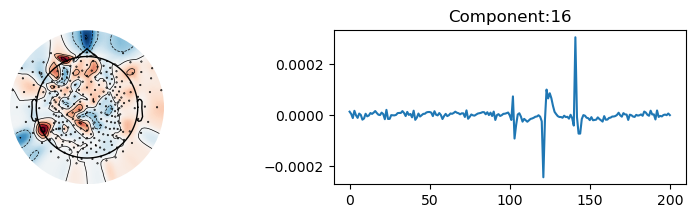

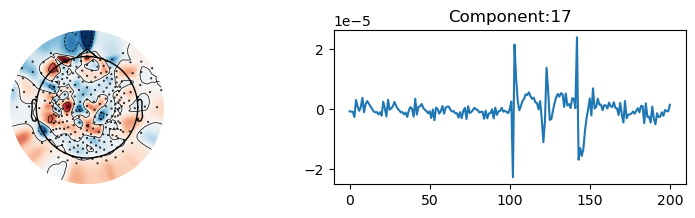

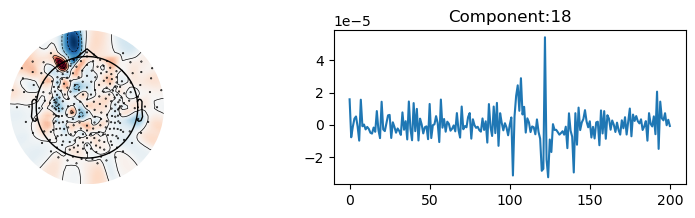

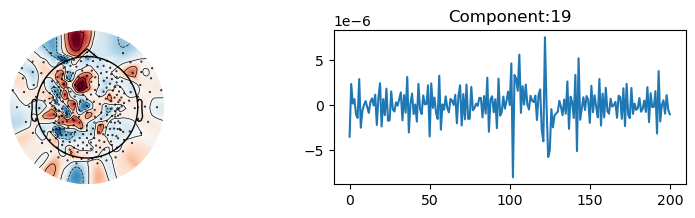

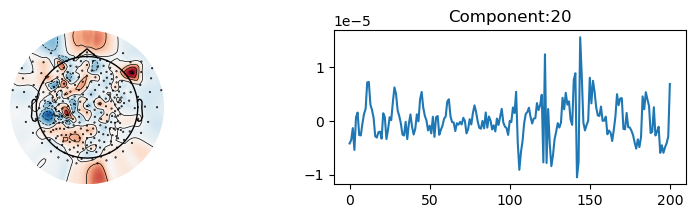

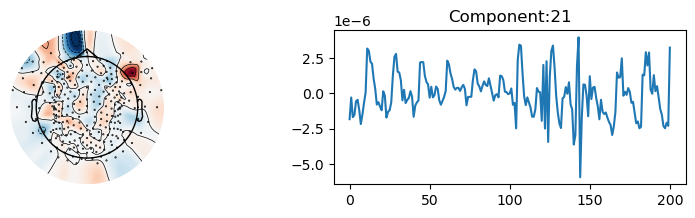

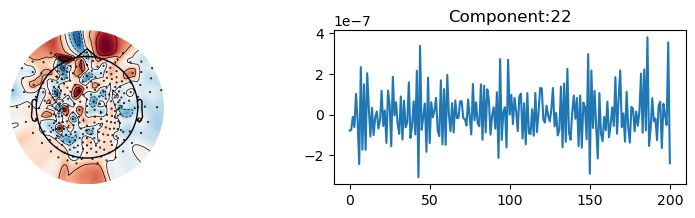

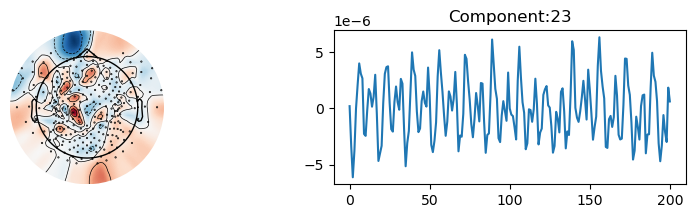

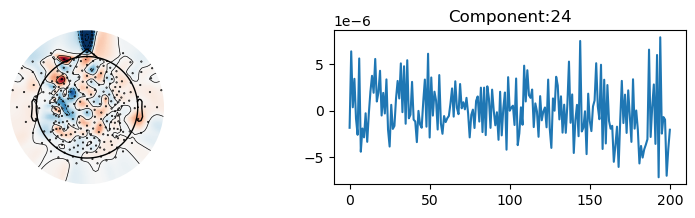

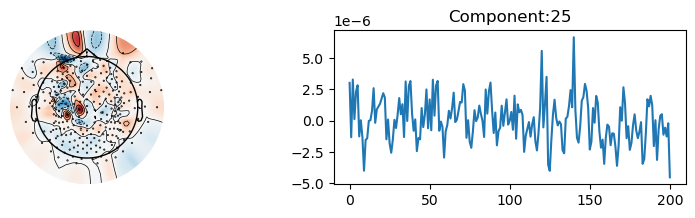

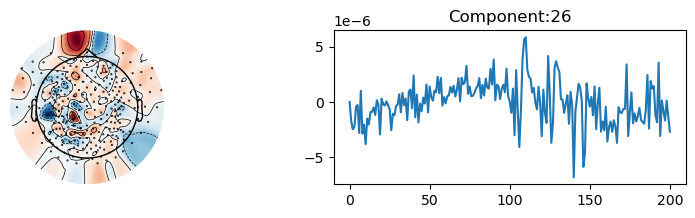

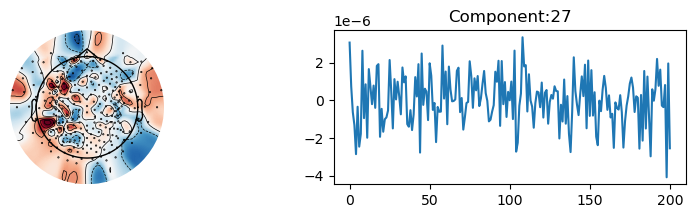

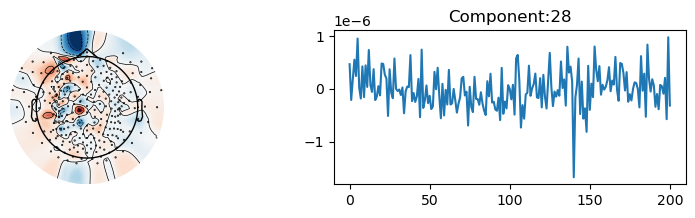

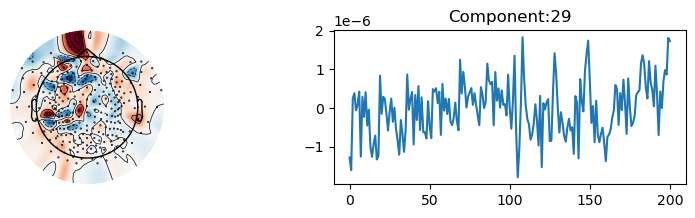

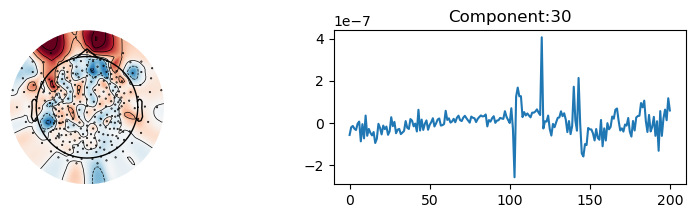

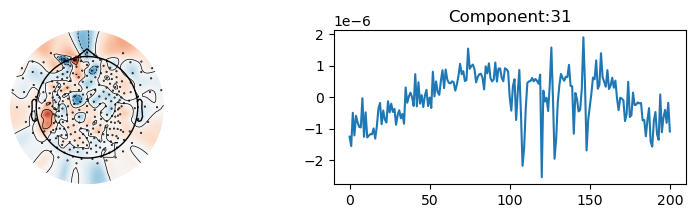

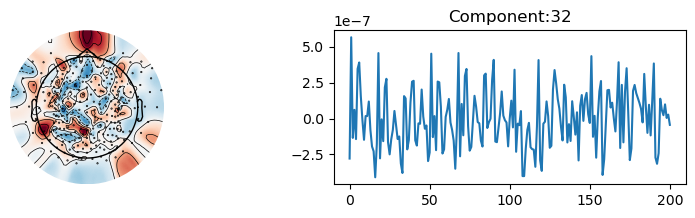

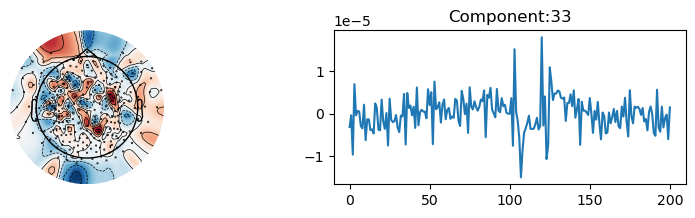

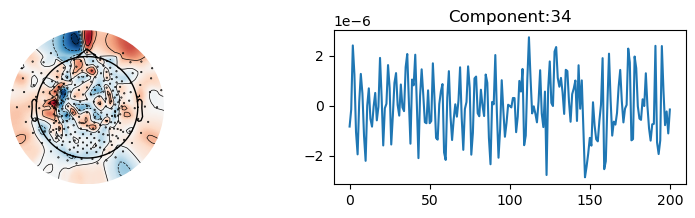

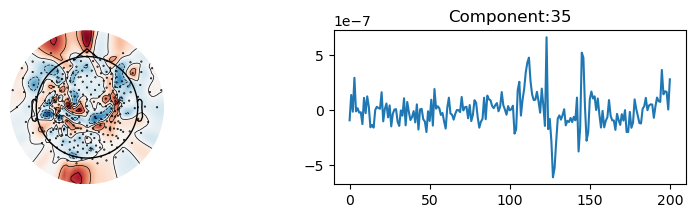

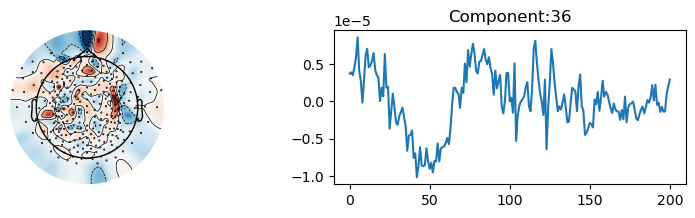

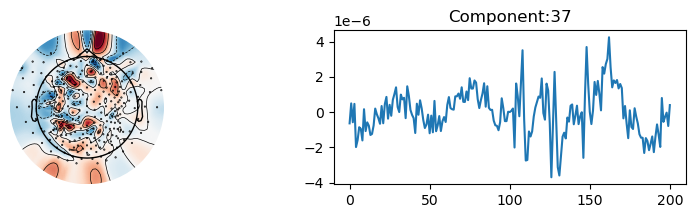

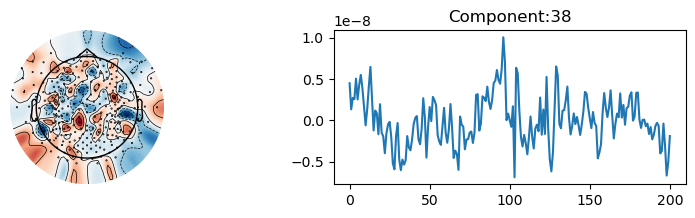

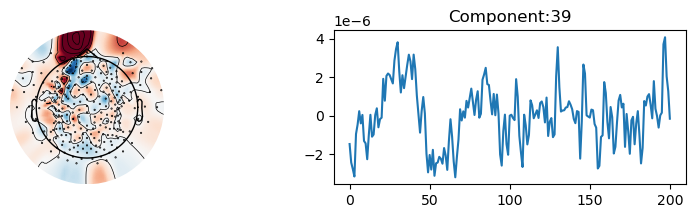

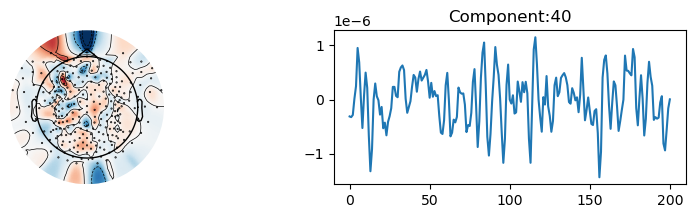

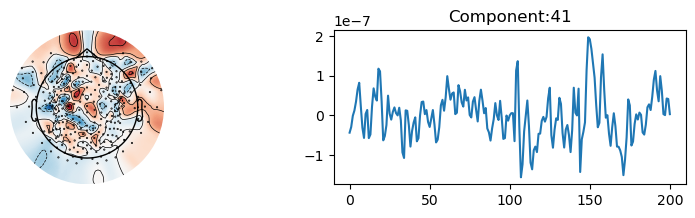

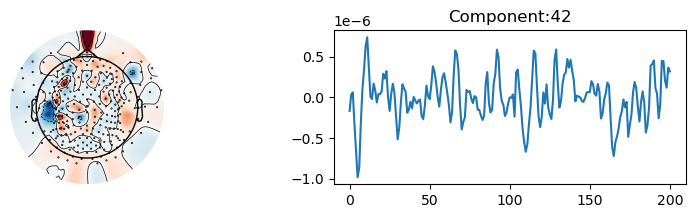

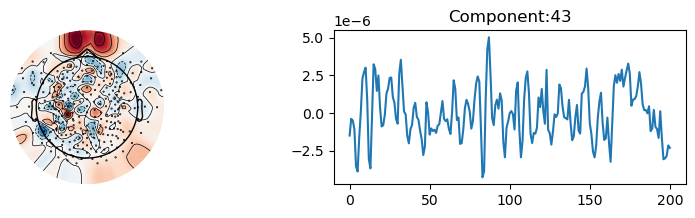

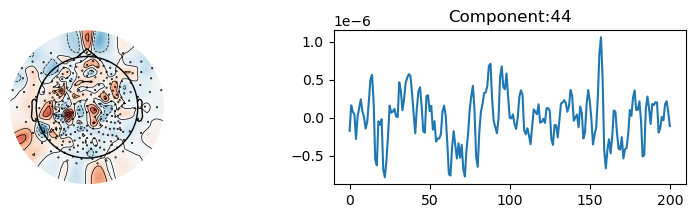

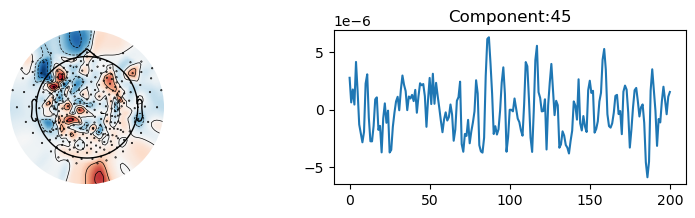

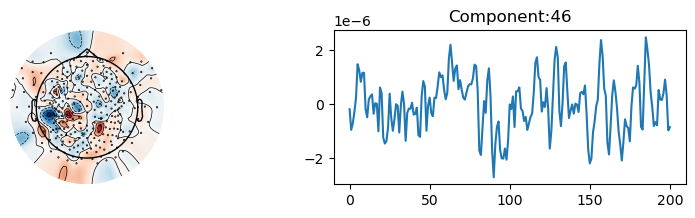

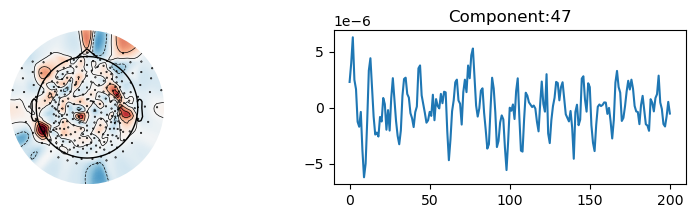

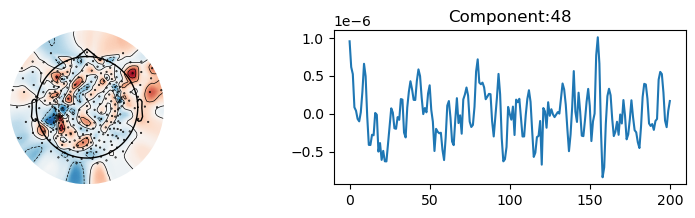

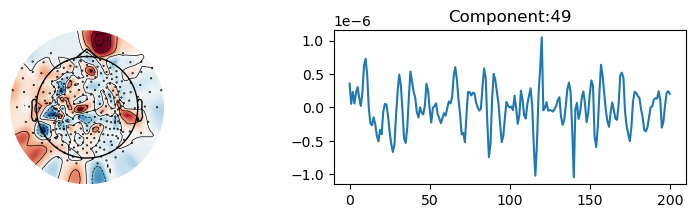

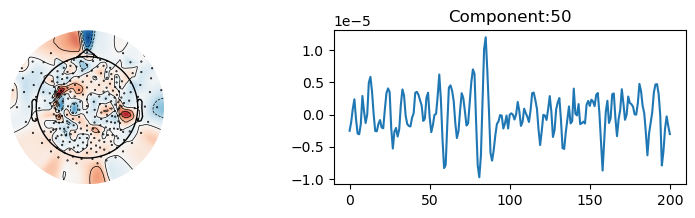

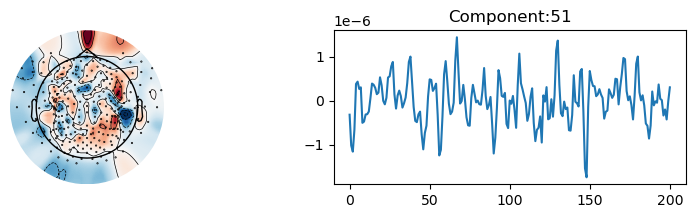

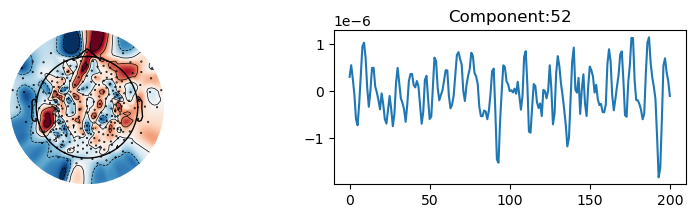

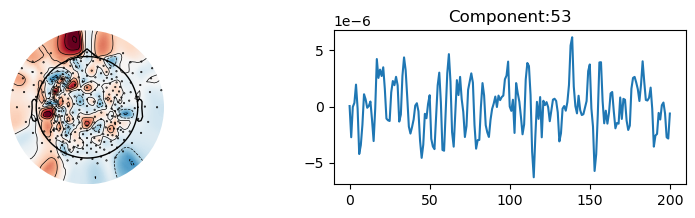

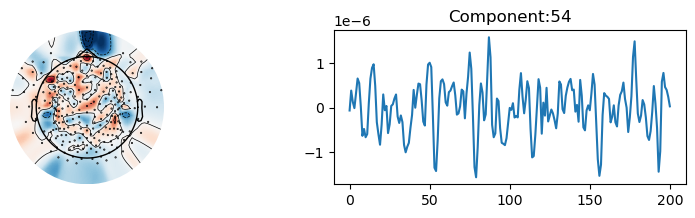

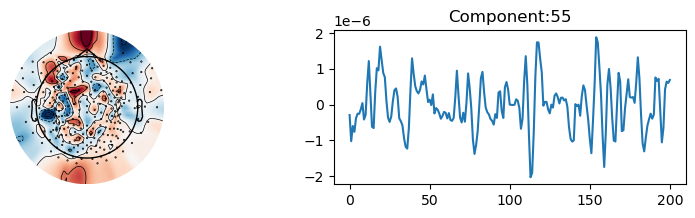

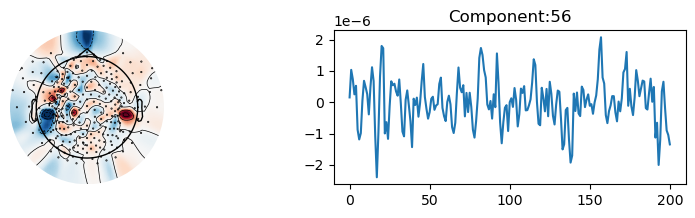

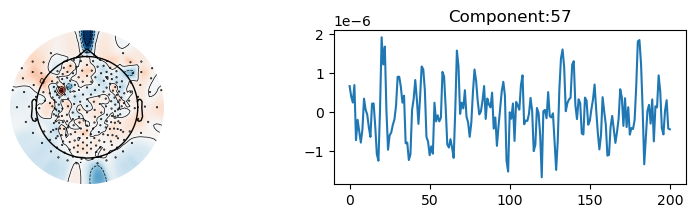

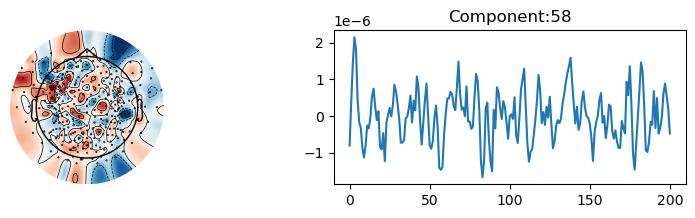

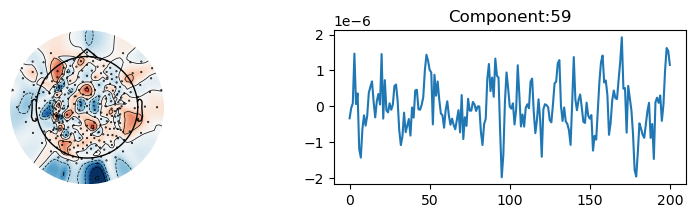

In [21]:
%matplotlib inline
# Plot images of 2D factors
for i in range(3):
    plt.figure(figsize=(5,5))
    plt.imshow(tucker_decomp.factors[i],aspect='auto',interpolation='nearest')
    plt.title("Tucker  "+str(i))

# Plot scalp maps and time series corresponding to tensor decomposition components
# Tucker 2 components better capture waveforms of TMS artifact without notch filter applied
for i in range(60):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,2))
    ax2.plot(tucker_diag[i]*tucker_decomp.factors[2][:,i])
    ax2.set_title("Component:"+str(i))
    mne.viz.plot_topomap(tucker_decomp.factors[1][:,i], pos=epochs.info, axes=ax1)

In [25]:
# Zero out first n components to try and remove artifact
# how to apply this directly to the raw signal?
tucker_decomp.factors[2][:,0:31] = 0.0

Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated


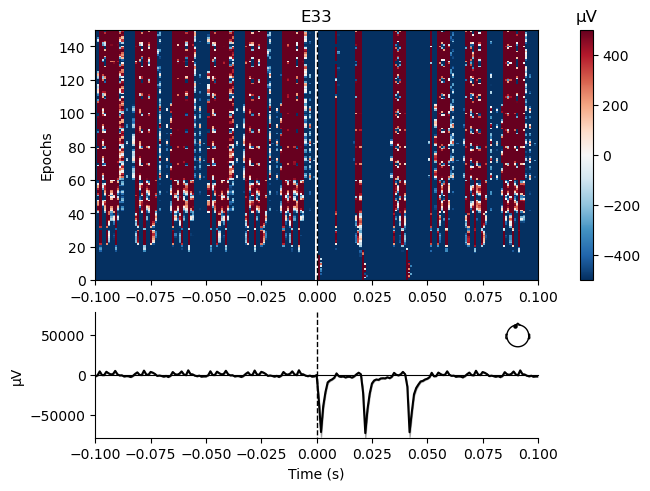

Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated


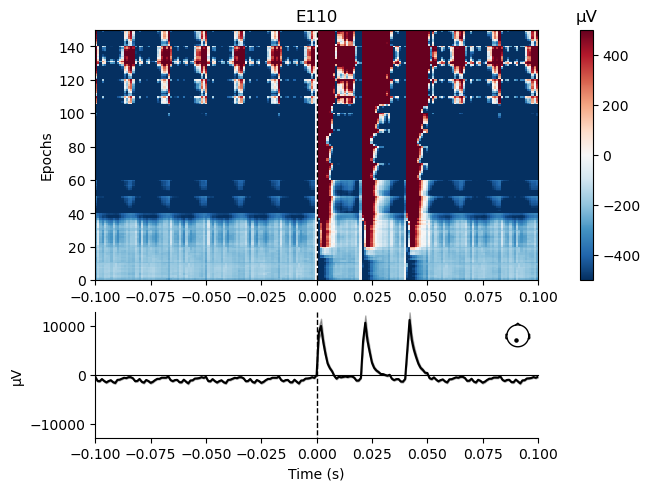

In [26]:
#%matplotlib qt
# Plot channel over epochs pre artifact removal
fig = epochs.plot_image(picks=['E33'], vmin=-500, vmax=500)
fig[0].axes[1].set_ylim([-500,500])
fig[0]
fig = epochs.plot_image(picks=['E110'], vmin=-500, vmax=500)
fig[0].axes[1].set_ylim([-500,500])
fig[0] ;

Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated


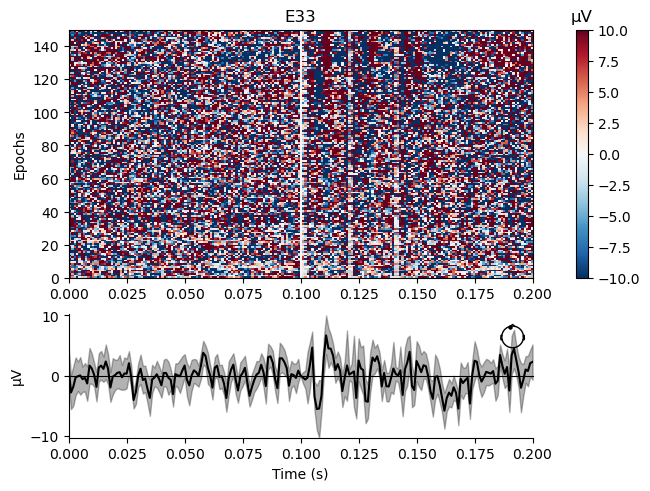

Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated


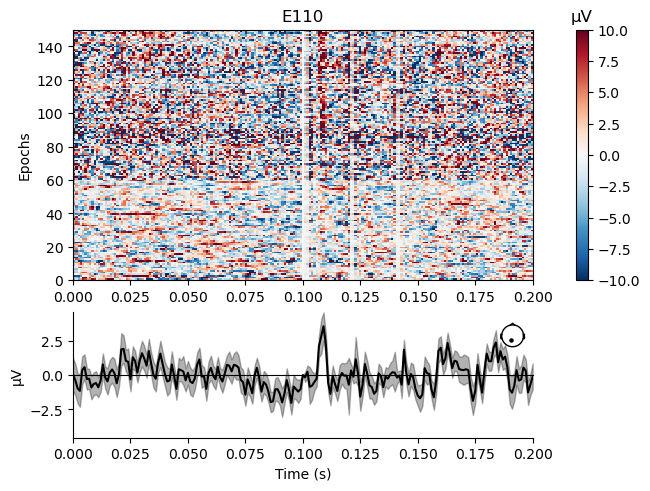

In [27]:
# Plot channel over epochs post artifact removal
tensor_cleaned = tl.tucker_to_tensor(tucker_decomp)
tensor_cleaned = np.concatenate((tensor_cleaned,epoch_stim),axis=1)
epochs_tuckered = mne.EpochsArray(tensor_cleaned,epochs.info)

fig = epochs_tuckered.plot_image(picks=['E33'], vmin= -10, vmax= 10)
fig[0].axes[1].set_ylim([-10,10])
fig[0]
fig = epochs_tuckered.plot_image(picks=['E110'], vmin= -10, vmax= 10)
fig[0].axes[1].set_ylim([-10,10])
fig[0] ; 

#### how to get back to non-epoched data for notch filtering? need to filter epochs_tuckered

Should not glue epochs back together because it causes edge artifacts

In [100]:
epochs_tuckered.info

<Info | 11 non-empty values
 bads: 1 items (VREF)
 ch_names: E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, ...
 chs: 257 EEG, 2 Stimulus
 custom_ref_applied: False
 device_info: 1 item (dict)
 dig: 260 items (3 Cardinal, 257 EEG)
 highpass: 1.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2023-04-11 01:36:42 UTC
 nchan: 259
 projs: []
 sfreq: 1000.0 Hz
 utc_offset: -0400
>

In [101]:
# Construct new raw object from epoched data for notch filtering and bad channel rejection
X = np.concatenate(epochs_tuckered.get_data(), axis=1) # new numpy array of appended epochs
raw_tuckered = mne.io.RawArray(X, raw_filt.info)
#treatment_autoreject.set_montage(montage)
#treatment_autoreject.save(data_path+data_fname.split('.')[0]+'_autoreject_raw'+'.fif',overwrite=True)
raw_tuckered.info

Creating RawArray with float64 data, n_channels=259, n_times=30150
    Range : 0 ... 30149 =      0.000 ...    30.149 secs
Ready.


/var/folders/bf/tx13kltn043fzjw05wb4ck0w0000gn/T/ipykernel_20032/2172921730.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = np.concatenate(epochs_tuckered.get_data(), axis=1) # new numpy array of appended epochs


<Info | 11 non-empty values
 bads: 1 items (VREF)
 ch_names: E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, ...
 chs: 257 EEG, 2 Stimulus
 custom_ref_applied: False
 device_info: 1 item (dict)
 dig: 260 items (3 Cardinal, 257 EEG)
 highpass: 1.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2023-04-11 01:36:42 UTC
 nchan: 259
 projs: []
 sfreq: 1000.0 Hz
 utc_offset: -0400
>

In [102]:
raw_tuckered._data.shape

(259, 30150)

In [103]:
raw_tuckered.get_data()

array([[-7.54112136e-06, -1.00712769e-05, -2.40735368e-05, ...,
        -1.22210282e-05,  1.34563559e-05,  1.36159780e-05],
       [-7.38434991e-06,  1.20440300e-05, -2.41408801e-05, ...,
        -1.49020850e-05,  4.14273384e-06,  1.04144781e-05],
       [ 4.66928120e-06,  3.34685593e-05,  3.70179706e-05, ...,
        -1.28827849e-05,  1.42038823e-06,  1.09408845e-05],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

### Notch filter for 60Hz noise

MNE has not added the functionality to notch_filter to work with epochs yet, so notch filter the reconstructed raw_tuckered signal

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


/Users/Bella/mambaforge/envs/clean/lib/python3.12/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/Users/Bella/mambaforge/envs/clean/lib/python3.12/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


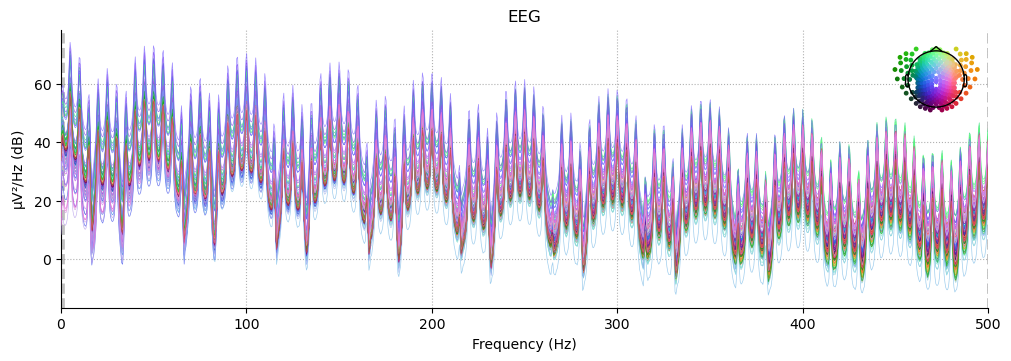

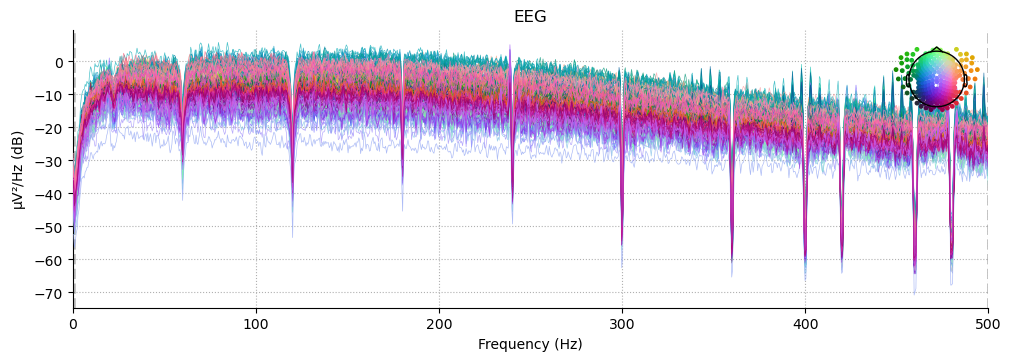

In [104]:
#def notch(epochs_tuckered, notch_freqs, notch_widths):
    #notch_freqs = np.array(notch_freqs)
    #notch_widths = np.asarray(notch_widths)
    #raw_notch = raw.copy().notch_filter(freqs=notch_freqs, notch_widths=notch_widths, verbose='warning')
    #return raw_notch

# Set notch filter at 60Hz and harmonics
notch_freqs = [60,120,180,240,300,360,400,420,460,480]
#notch_widths = [8.0] # This is set pretty wide as there is very significant 60Hz noise in this data

# Notch filter
#epochs_filt = notch(notch_freqs=notch_freqs, notch_widths=notch_widths)
raw_notch = raw_tuckered.copy().notch_filter(freqs=notch_freqs)

# Plot resulting PSDs for raw and filtered data
fig = raw_filt.compute_psd().plot(show=True, exclude='bads')
sns.despine() ;

fig = raw_notch.compute_psd().plot(show=True, exclude='bads')
sns.despine() ;

In [105]:
# Read DIN1 events for TMS data create epochs based on stim triggers
events_notch = mne.find_events(raw_notch, stim_channel = 'DIN1')
epochs_notch = mne.Epochs(raw_notch, events_notch, tmin=-0.1, tmax=0.1, baseline=(0, 0), preload=True)
print(epochs_notch)  # 600 epochs created for Event ID '1'

150 events found on stim channel DIN1
Event IDs: [1]
Not setting metadata
150 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 150 events and 201 original time points ...
0 bad epochs dropped
<Epochs |  150 events (all good), -0.1 – 0.1 s, baseline 0 – 0 s, ~59.9 MB, data loaded,
 '1': 150>


Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated


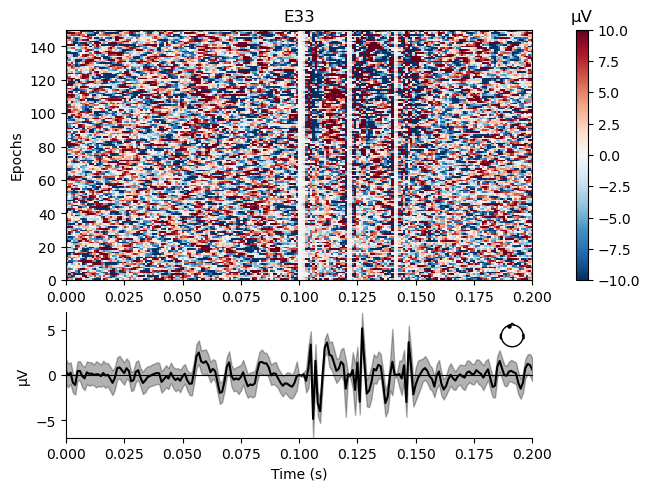

Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated


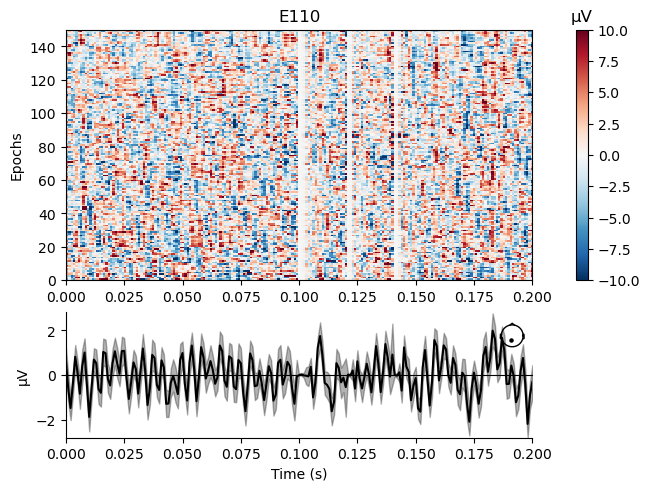

In [106]:
# Plot ERP post tucker decomposition, pre notch filtering
fig = epochs_tuckered.plot_image(picks=['E33'], vmin= -10, vmax= 10)
fig[0].axes[1].set_ylim([-10,10])
fig[0]
fig = epochs_tuckered.plot_image(picks=['E110'], vmin= -10, vmax= 10)
fig[0].axes[1].set_ylim([-10,10])
fig[0] ; 

Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated


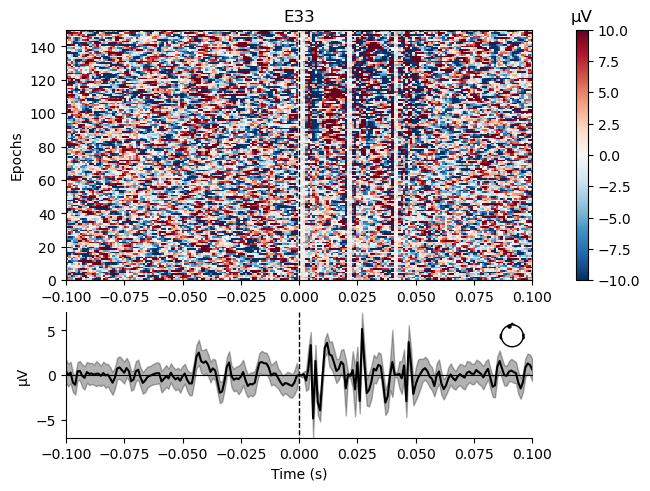

Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated


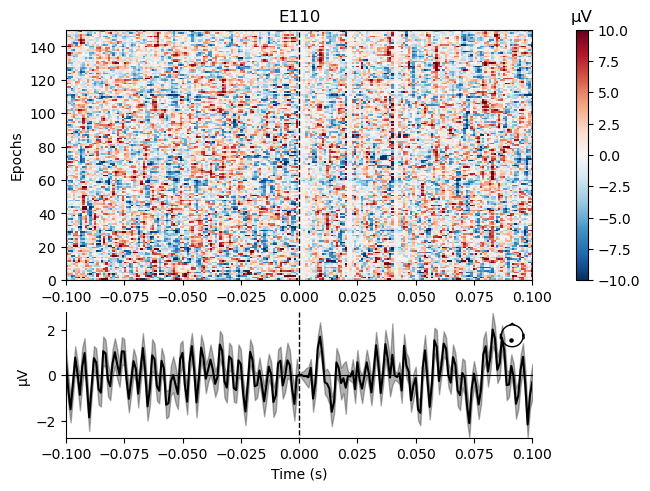

In [107]:
# Plot ERP traces after notch filtering
fig = epochs_notch.plot_image(picks=['E33'], vmin= -10, vmax= 10)
fig[0].axes[1].set_ylim([-10,10])
fig[0]
fig = epochs_notch.plot_image(picks=['E110'], vmin= -10, vmax= 10)
fig[0].axes[1].set_ylim([-10,10])
fig[0] ; 

#### Remove Noisy Channels

Use NoisyChannels to find and remove bad channels.

For now, use this just to identify noisy channels and update bad channels list

In [ ]:
from pyprep.find_noisy_channels import NoisyChannels

nc = NoisyChannels(raw_filt.copy(), random_state=42)
nc.find_all_bads(channel_wise=False)
bad_channels = nc.bad_by_deviation + nc.bad_by_hf_noise + nc.bad_by_dropout + nc.bad_by_ransac + nc.bad_by_correlation

# Print bad channel info
print('  Removed '+str(len(bad_channels))+' total:')
print('  --> Removed '+str(len(nc.bad_by_deviation))+' channels found to be bad by deviation.')
print('  --> Removed '+str(len(nc.bad_by_hf_noise))+' channels found to be bad by high frequency noise.')
print('  --> Removed '+str(len(nc.bad_by_correlation))+' channels found to be bad by correlations.')
print('  --> Removed '+str(len(nc.bad_by_dropout))+' channels found to be bad by dropout.')
print('  --> Removed '+str(len(nc.bad_by_ransac))+' channels found to be bad by RANSAC.')

# Add noisy channels to bad channels list
raw_filt.info['bads'].extend(bad_channels)

# Save out fif of data with bad channel correction
#treatment_filt.save(data_path+data_fname.split('.')[0]+'_noisychannels'+'.fif',overwrite=True)

# removed 31 total and interpolated 28 sensors

In [ ]:
print(raw_filt.info["bads"])
print("Data shape before interpolation:", raw_filt._data.shape)

In [ ]:
# Do bad channel rejection on raw.copy and apply bad channels to original raw by inputting theminto bad channels list
# then interpolate bad channels
raw_interpolated = raw_filt.interpolate_bads(reset_bads=True) # This will clear out data.info['bads']
print("Data shape post interpolation:", raw_interpolated._data.shape)
print(raw_interpolated.info["bads"])
print(type(raw_interpolated))

In [ ]:
# Create epochs again for bad segment rejection
events = mne.find_events(raw_interpolated, stim_channel = 'DIN1')
epochs_filt = mne.Epochs(raw_interpolated, events, tmin=-0.1, tmax=0.1, baseline=(0, 0), preload=True)

#### Reject bad segments

Use autoreject library to reject bad segments. Note this may take some time/memory with longer data sets.

In [ ]:
from autoreject import AutoReject, Ransac

def autoreject_bad_segments(epochs, method='autoreject'):
    # Use mne-compatible autoreject library to clean epoched data
    n_interpolates = np.array([1, 4, 32])
    consensus_percs = np.linspace(0, 1.0, 11)

    if method=='autoreject':
        ar = AutoReject(n_interpolates, consensus_percs, thresh_method='bayesian_optimization', random_state=42)
    elif method=='ransac':
        ar = Ransac()
    else:
        raise pipeline_log.ValueError("Specified bad segment method not implemented. Current options are 'autoreject' and 'ransac'.")
    epochs = ar.fit_transform(epochs)
    return epochs, ar

epochs_filt, ar = autoreject_bad_segments(epochs_filt, method='autoreject')

# dropped 189 epochs

In [ ]:
# Generate rejected segment plot
ar.get_reject_log(epochs_filt).plot(show=True) ;


In [ ]:
epochs_filt.plot() ;
epochs_filt.info

In [ ]:
epochs_filt._data.shape

In [ ]:
Y = epochs_filt.get_data()
Y.data.shape

In [ ]:
print(epochs_filt)
print(type(epochs_filt))

In [ ]:
# Plot signal over epochs and time before bad segment rejection
fig = epochs_tuckered.plot_image(picks=['E33'], vmin= -10, vmax= 10)
fig[0].axes[1].set_ylim([-10,10])
fig[0] 

# Plot after notch filter, bad channel, and bad segment rejection
fig = epochs_filt.plot_image(picks=['E33'], vmin= -10, vmax= 10)
fig[0].axes[1].set_ylim([-10,10])
fig[0] ;

#### Replot EOG epochs after bad channel and segment rejection

In [ ]:
eog_epochs = mne.preprocessing.create_eog_epochs(treatment_autoreject, baseline=(-0.5, -0.2), ch_name=['E32','E241','E25','E238'])
eog_epochs.plot_image(combine="mean")
eog_epochs.average().plot_joint()

For reloading saved clean data if jupyter notebook barfs

In [ ]:
#treatment_autoreject = mne.io.Raw(data_path+data_fname.split('.')[0]+'_autoreject_raw'+'.fif', preload=True )


### Replot Epochs over time after notch filtering and bad channel + bad segment rejection

In [ ]:
fig = epochs_filt.plot_image(picks=['E33'], vmin= -10, vmax= 10)
fig[0].axes[1].set_ylim([-10,10])
fig[0] ;

### Run ICA on cleaned data

Try using FastICA vs Picard

In [ ]:
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs
epochs_autoreject = epochs_filt.copy()

ica = ICA(n_components=250, max_iter="auto", random_state=97, method="picard")
ica.fit(epochs_autoreject)

explained_var_ratio = ica.get_explained_variance_ratio(epochs_autoreject)
for channel_type, ratio in explained_var_ratio.items():
    print(
        f"Fraction of {channel_type} variance explained by all components: " f"{ratio}"
    )

Plot ICA spatial sources

In [ ]:
ica.plot_components()


Plot ICA source traces

In [ ]:
ica.plot_sources(epochs_autoreject, show_scrollbars=False)


Plot cleaned data traces

In [ ]:
epochs_autoreject.plot()

In [ ]:
from mne_icalabel import label_components

# Filter data to icalabel requirements
#mne_filt = treatment_autoreject.filter(l_freq=1.0, h_freq=99.0, verbose='warning')
mne_filt = epochs_autoreject.copy()

# Use label_components function from ICLabel library to classify ICs and get their estimated probabilities
print('  Using ICALabel to classify independent components.')
ic_labels = label_components(mne_filt, ica, method="iclabel")
labels = ic_labels["labels"]
    
# Exclude ICs not in 'keep' list and reconstruct cleaned raw data
keep=['brain']
exclude_idx = [idx for idx, label in enumerate(labels) if label not in keep]
include_idx = [idx for idx, label in enumerate(labels) if label in keep]
print(f"  Excluding these ICA components: {exclude_idx}")
print(f"  Including these ICA components: {include_idx}")
cleaned = ica.apply(epochs_autoreject, exclude=exclude_idx, verbose=False)

# icalabel only kept component 52 and excluded the rest... doing a terrible job of telling what's "brain"

In [ ]:
epochs_autoreject.plot()  # ICA removed all visible signal

### Source localization